In [81]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('data0305.csv')
data

,Date,Store_id,SKU_id,Promo,Demand,Regular_Price,Actual_Price,weekday,monthday,is_weekend,...,Demand_lag42d_w14D_keySKU_id_Store_id_preagmean_agperc90_is_weekend_dynamic_rolling,Demand_lag42d_w21D_keySKU_id_Store_id_preagmean_agmean_is_weekend_dynamic_rolling,Demand_lag42d_w21D_keySKU_id_Store_id_preagmean_agmedian_is_weekend_dynamic_rolling,Demand_lag42d_w21D_keySKU_id_Store_id_preagmean_agperc10_is_weekend_dynamic_rolling,Demand_lag42d_w21D_keySKU_id_Store_id_preagmean_agperc90_is_weekend_dynamic_rolling,Demand_lag42d_w28D_keySKU_id_Store_id_preagmean_agmean_is_weekend_dynamic_rolling,Demand_lag42d_w28D_keySKU_id_Store_id_preagmean_agmedian_is_weekend_dynamic_rolling,Demand_lag42d_w28D_keySKU_id_Store_id_preagmean_agperc10_is_weekend_dynamic_rolling,Demand_lag42d_w28D_keySKU_id_Store_id_preagmean_agperc90_is_weekend_dynamic_rolling,Promo_percent
0,2015-01-01,1,1,0.0,22.0,163.78,163.78,3,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,2015-01-01,53,1,0.0,3.0,163.78,163.78,3,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,2015-01-01,54,1,0.0,6.0,163.78,163.78,3,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,2015-01-01,49,1,0.0,6.0,163.78,163.78,3,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,2015-01-01,55,1,0.0,16.0,163.78,163.78,3,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92881,2016-06-19,92,2,0.0,NaN,133.06,133.06,6,19,1,...,115.5,67.500000,81.5,0.0,121.0,51.375,37.5,0.0,119.0,0.000000
92882,2016-06-19,66,1,1.0,NaN,134.96,125.04,6,19,1,...,69.3,224.666667,67.5,52.0,554.5,201.875,84.5,55.2,487.1,0.073503
92883,2016-06-19,30,1,1.0,NaN,134.96,125.04,6,19,1,...,112.4,148.000000,108.0,66.0,270.0,129.500,88.0,66.3,233.6,0.073503
92884,2016-06-19,76,1,1.0,NaN,134.96,125.04,6,19,1,...,64.2,195.333333,61.0,33.0,492.0,166.875,69.0,38.6,470.0,0.073503


## No lag features

In [82]:
data = data.drop(data.columns[data.columns.str.contains('lag')], axis=1)


In [83]:
from itertools import product

target = 'Demand'
id_cols = ['SKU_id', 'Store_id']
date_col = 'Date'

data[date_col] = pd.to_datetime(data[date_col])
for c, sku, store in product(data.drop([date_col, target], axis=1).columns, 
                             data[id_cols[0]].unique(), data[id_cols[1]].unique()):
    cond = (data[id_cols[0]] == sku) & (data[id_cols[1]] == store)
    data.loc[cond, c] = data[cond][c].fillna(data[cond][c].mean())
    
for id_ in id_cols:
    for c in data.drop([date_col, target], axis=1).columns:
        for sku in data[id_].unique():
            cond = (data[id_] == sku)
            data.loc[cond, c] = data[cond][c].fillna(data[cond][c].mean())
    if data[data.drop([date_col, target], axis=1).columns].isna().sum().sum() == 0:
        break

In [84]:
data = data.set_index('Date')

In [85]:
train = data[data['Demand'].notna()]
test = data[data['Demand'].isna()]

In [86]:
X_train, X_test, y_train, y_test = train.drop('Demand', axis=1), test.drop('Demand', axis=1), train['Demand'], test['Demand']



In [87]:
from xgboost import XGBRegressor as xgb

model = xgb()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

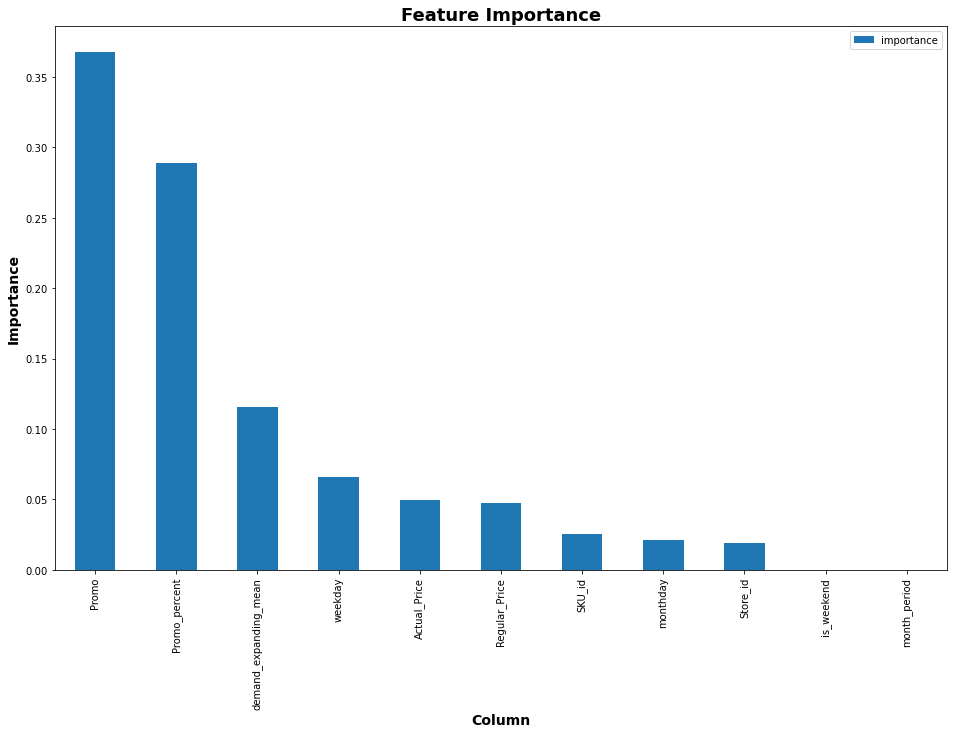

In [88]:
import matplotlib.pyplot as plt

fi = pd.DataFrame({'column': X_train.columns, 'importance': model.feature_importances_})
fi.sort_values('importance', ascending=False).head(15).set_index('column').plot.bar(figsize=(16, 10))
plt.ylabel('Importance', weight='bold', size=14)
plt.xlabel('Column', weight='bold', size=14)
plt.title('Feature Importance', weight='bold', size=18)
plt.show()

In [94]:
## как и ожидалось самые важные признаки это promoи promo_percent

In [90]:
test['pred'] = y_pred

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_63195/3359158094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = y_pred


In [93]:
test.reset_index().sort_values(['SKU_id', 'Store_id', 'Date'])[['pred']].reset_index().drop('index', axis=1).\
rename(columns={'pred': 'Demand'}).to_csv('xgb.csv', index_label='id')




## With lag features

In [ ]:
from itertools import product

target = 'Demand'
id_cols = ['SKU_id', 'Store_id']
date_col = 'Date'

data[date_col] = pd.to_datetime(data[date_col])
for c, sku, store in product(data.drop([date_col, target], axis=1).columns, 
                             data[id_cols[0]].unique(), data[id_cols[1]].unique()):
    cond = (data[id_cols[0]] == sku) & (data[id_cols[1]] == store)
    data.loc[cond, c] = data[cond][c].fillna(data[cond][c].mean())
    
for id_ in id_cols:
    for c in data.drop([date_col, target], axis=1).columns:
        for sku in data[id_].unique():
            cond = (data[id_] == sku)
            data.loc[cond, c] = data[cond][c].fillna(data[cond][c].mean())
    if data[data.drop([date_col, target], axis=1).columns].isna().sum().sum() == 0:
        break

data = data.set_index('Date')

train = data[data['Demand'].notna()]
test = data[data['Demand'].isna()]

X_train, X_test, y_train, y_test = train.drop('Demand', axis=1), test.drop('Demand', axis=1), train['Demand'], test['Demand']



from xgboost import XGBRegressor as xgb

model = xgb()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


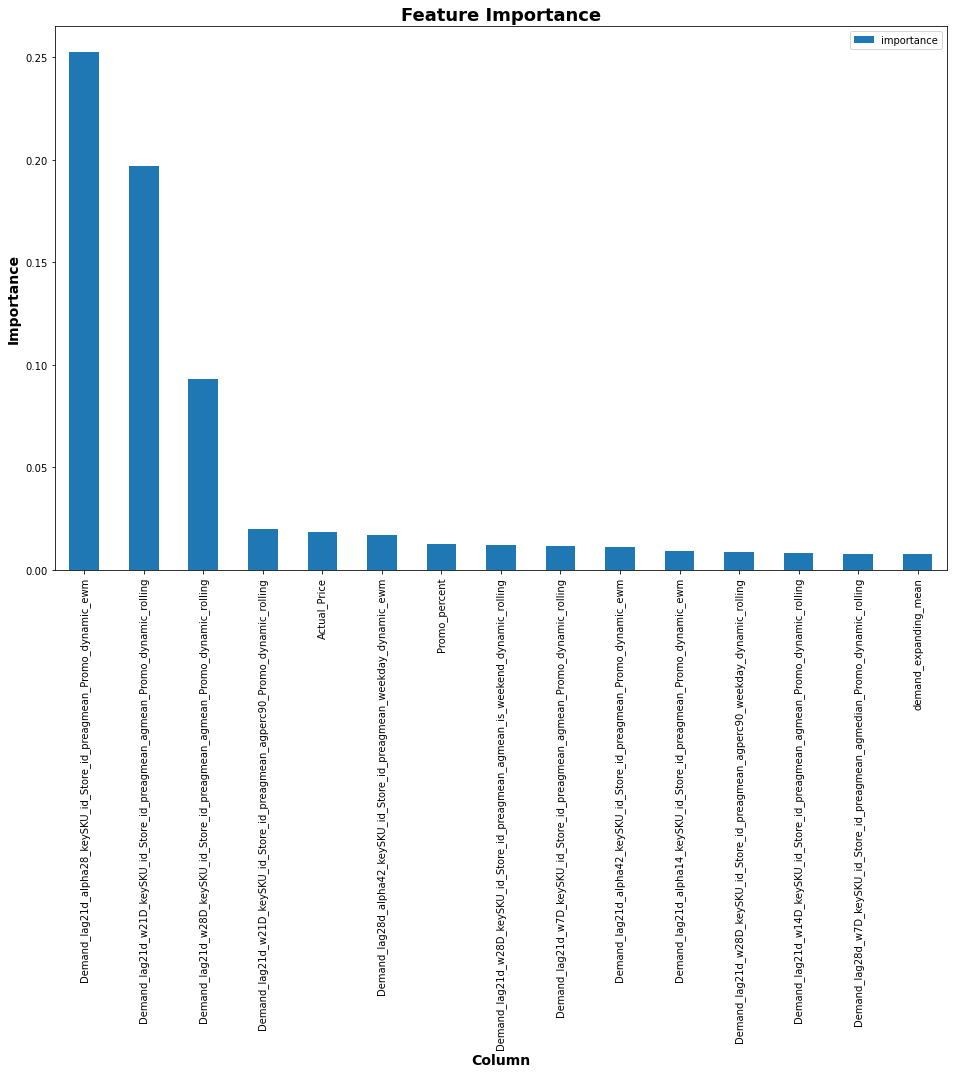

In [52]:
import matplotlib.pyplot as plt

fi = pd.DataFrame({'column': X_train.columns, 'importance': model.feature_importances_})
fi.sort_values('importance', ascending=False).head(15).set_index('column').plot.bar(figsize=(16, 10))
plt.ylabel('Importance', weight='bold', size=14)
plt.xlabel('Column', weight='bold', size=14)
plt.title('Feature Importance', weight='bold', size=18)
plt.show()

In [51]:
## Важными являются группировки по Промо, в большинстве своем с лагом 21, входят и percentile и mean и median

test.reset_index().sort_values(['SKU_id', 'Store_id', 'Date'])[['pred']].reset_index().drop('index', axis=1).\
rename(columns={'pred': 'Demand'}).to_csv('xgb.csv', index_label='id')

